# Redukce dimenzionality a binární klasifikace

## Zdroj dat

 * Zdrojem dat je soubor `train.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.

# Řešení

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 420

In [2]:
def plot_image(img: np.ndarray, label: int = None):
    """ Plot image with optional label param """
    
    fig, ax = plt.subplots(figsize = (4, 4))
    ax.axis('off')
    ax.imshow(img.resize(28, 28), cmap = plt.cm.gray)
    
    if label is not None: ax.set_title(ITEM[label])
    
    plt.show()
    
def plot_images(images: np.ndarray, labels: np.ndarray = None, rows: int = 2, cols: int = 8, print_labels: bool = True) -> None:
    """ Plot images from given ndarray with labels vec """
        
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 2, rows * 2))
    axes = axes.ravel()

    for i in range(rows * cols):
        axes[i].axis('off')
        axes[i].imshow(images[i].reshape(28, 28), cmap = plt.cm.gray)
        
        if labels is not None and print_labels: axes[i].set_title(ITEM[labels[i]])
        
    plt.show()

## Základní analýza dat
Zde se podívám na základní strukturu dat.

In [3]:
# load data
data = pd.read_csv('train.csv')

# set label encoding
ITEM = { 0 : 'T-shirt/top', 1 : 'Trouser' }

In [4]:
# print null values, shape and labels

print('NULL values:', data.isnull().sum().sum())
print('shape:', data.shape)
print('unique labels:', data.iloc[:, 0].unique())

NULL values: 0
shape: (2400, 785)
unique labels: [1 0]


In [5]:
display(data.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0


In [6]:
X, y = data.drop(['label'], axis = 1).to_numpy(), data['label'].to_numpy()

### Vykreslení obrázků
Zobrazím si 30 prvních obrázků s jejich názvem.

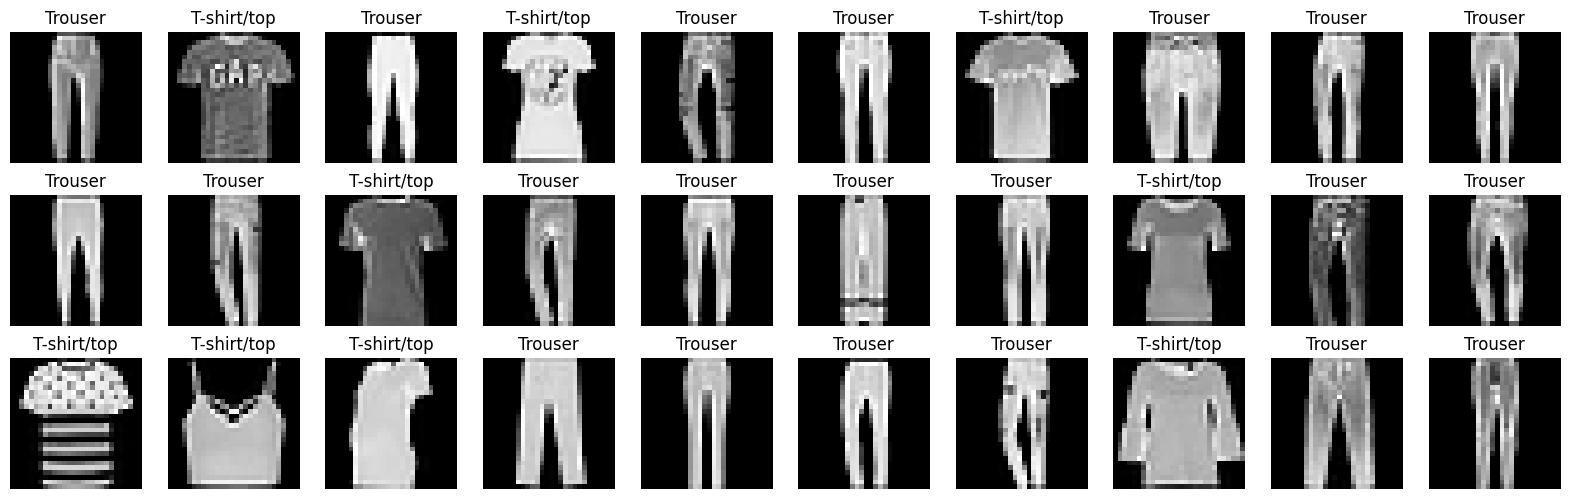

In [7]:
plot_images(X, y, 3, 10)

Není překvapením, že dataset obsahuje obrázky kalhot a triček.

### Počet triček a kalhot

In [8]:
for key, value in zip(*np.unique(y, return_counts = True)):
    print(f'{ITEM[key]:15}: {value}')

T-shirt/top    : 1199
Trouser        : 1201


### Histogram pixelů
Pro vykreslení histogramu použiju bar chart, který nám pro každý pixel bude udávat součet všech hodnot daného pixelu v datasetu.

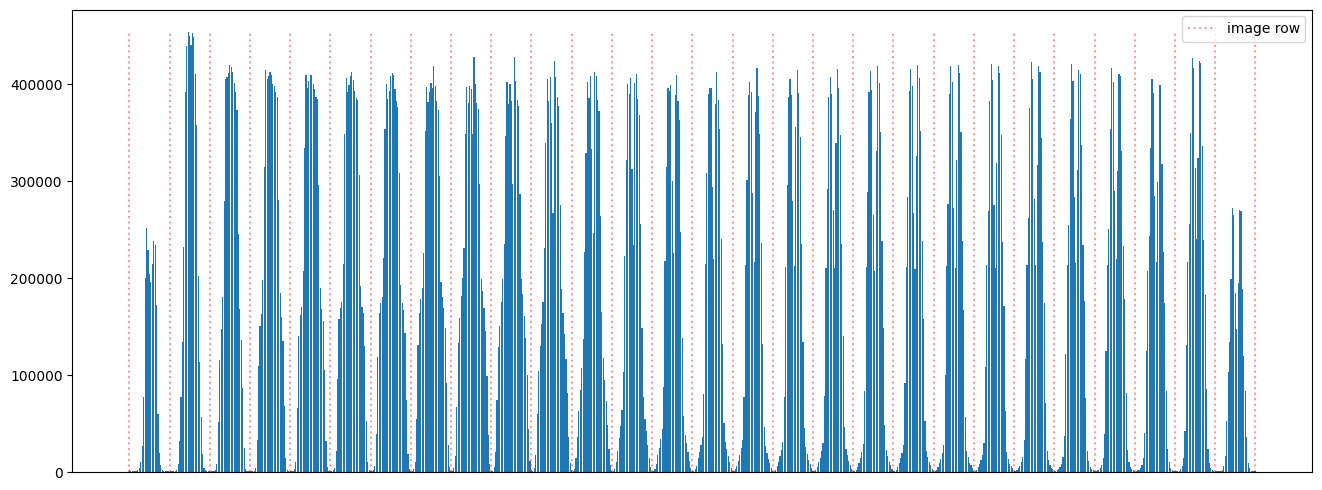

In [9]:
fig, ax = plt.subplots(figsize = (16, 6))

# sum all values
pixel_values_sum = data[1:].agg(['sum'])

# plot barchart with row delimeter lines
ax.bar(list(pixel_values_sum.columns), list(pixel_values_sum.loc['sum']))
for i in np.arange(0, 29):
    ax.vlines(i * 28, ymin = 0, ymax = np.max(pixel_values_sum), color = 'r', linestyles = ':', alpha = 0.4)

ax.set_xticks([])
ax.legend(['image row'])

plt.show()

Na tomto grafu můžeme pozorovat, že hodnoty pixelů oscilují.

To znamená, že právě spíše krajní pixely mají menší hodnotu, ke středu obrázku jí mají vyšší a následně zase hodnota pixelů upadá.

Zároveň první a poslední řádky obrázku mají menší hodnoty pixelů než zbytek řádků.

### Statistické hodnoty pixelů
Pro každý pixel vypočítám průměr a rozptyl. Tyto hodnoty následně vykreslím pomocí heatmapy.

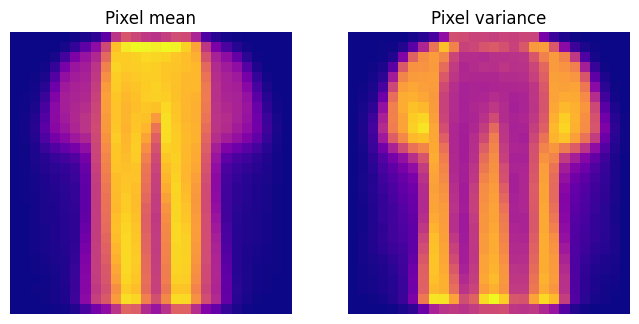

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))

axes[0].imshow(np.mean(X, axis = 0).reshape(28, 28), cmap = plt.cm.plasma)
axes[0].axis('off')
axes[0].set_title('Pixel mean')

axes[1].imshow(np.var(X, axis = 0).reshape(28, 28), cmap = plt.cm.plasma)
axes[1].axis('off')
axes[1].set_title('Pixel variance')

plt.show()

Z obrázku průměrných hodnot můžeme vidět, že pixely na krajích jsou spíše s nízkou hodnotou. Oproti tomu ve středu jsou ve tvaru kalhot hodnoty vysoké a k nim se občasně přidává tvar trička, které v sobě taktéž zahrnuje pixely z kalhot.

U rozptylu můžeme pozorovat, že se pixely na krajích a ve středu spíše nemění v závisloti na záznamu, ale rozhodující část je právě ta ve tvaru trička.

V tuto chvíli mohu celkem s jistotou říct, že se klasifikátory budou rozhodovat spíše podle pixelů, které udávají tvar trička nad rámec kalhot.

## Tvorba modelů
V této sekci budu trénovat a vyhodnocovat modely **SVM**, **Naive bayes** a **LDA**.

In [11]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline


# split onto train, val, test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = SEED)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size = 0.25, random_state = SEED)

print('train:', Xtrain.shape, ytrain.shape)
print('val:', Xval.shape, yval.shape)
print('test:', Xtest.shape, ytest.shape)

train: (1440, 784) (1440,)
val: (480, 784) (480,)
test: (480, 784) (480,)


### SVM
Natrénuji model **SVC** pro klasifikaci s pomocí hyperparametrů: *C*, *kernel* a *degree (u poly. jádra)*. 
Ten se bude snažit naše data proložit nadrovinou tak, aby separoval obrazové body pomocí metody maximálního odstupu. SVM je efektivní i v prosterech s velkou dimenzí a jelikož se jedná o binární klasifikaci, tak bych tipoval, že model bude mít velmi dobrou přesnost.

Vyzkouším dohromday 12 různých SVC modelů. Ty se budou lišit metodou předzpracování dat **<bez úpravy, Standardizace, Normalizace, MinMax standardizace>** a typem jádrové funkce **<linear, poly, rbf>**.

In [12]:
from sklearn.svm import SVC

def train_svc(params, preprocessor = None) -> list:
    """ Train SVC with given params and preprocessor """
    
    train_score, val_score = [], []    
    param_grid = ParameterGrid(params)
        
    for params in param_grid:
        
        svc = Pipeline([
            ('prep', preprocessor),
            ('SVC', SVC(**params, random_state = SEED))
        ]).fit(Xtrain, ytrain)
        
        train_score.append(svc.score(Xtrain, ytrain))
        val_score.append(svc.score(Xval, yval))
    
    # train and return best SVC model
    best_params = param_grid[np.argmax(val_score)]
    best_svc = Pipeline([
        ('prep', preprocessor),
        ('SVC', SVC(**best_params, random_state = SEED))
    ]).fit(Xtrain, ytrain)
        
    return [best_svc, best_params, train_score, val_score]

In [13]:
%%time

trained_svc = {
    'None' : {},
    'Scaler' : {},
    'Norm' : {},
    'MinMax' : {}
}

# loop trough preprocessors 
for prep, name in zip([None, StandardScaler(), Normalizer(), MinMaxScaler()], trained_svc.keys()):
    
    # linear kernel
    print(f'training: linear kernel, {name} prep')
    trained_svc[name]['linear'] = train_svc({
        'kernel' : ['linear'],
        'C' : np.linspace(0.01, 100, 10),
    }, preprocessor = prep)
    
    # poly kernel
    print(f'training: poly kernel, {name} prep')
    trained_svc[name]['poly'] = train_svc({
        'kernel' : ['poly'],
        'degree' : np.arange(2, 11),
        'C' : np.linspace(0.01, 100, 10),
    }, preprocessor = prep)
    
    # rbf kernel
    print(f'training: rbf kernel, {name} prep')
    trained_svc[name]['rbf'] = train_svc({
        'kernel' : ['rbf'],
        'C' : np.linspace(0.01, 100, 10),
    }, preprocessor = prep)

training: linear kernel, None prep
training: poly kernel, None prep
training: rbf kernel, None prep
training: linear kernel, Scaler prep
training: poly kernel, Scaler prep
training: rbf kernel, Scaler prep
training: linear kernel, Norm prep
training: poly kernel, Norm prep
training: rbf kernel, Norm prep
training: linear kernel, MinMax prep
training: poly kernel, MinMax prep
training: rbf kernel, MinMax prep
CPU times: user 4min 4s, sys: 26.2 ms, total: 4min 5s
Wall time: 4min 5s


Pro každý model vykreslím graf průběhu ladění hyperparametrů s validační přesnosti.

None preprocessor:
linear val score: 0.985
poly   val score: 0.992
rbf    val score: 0.994
----------------------------------------


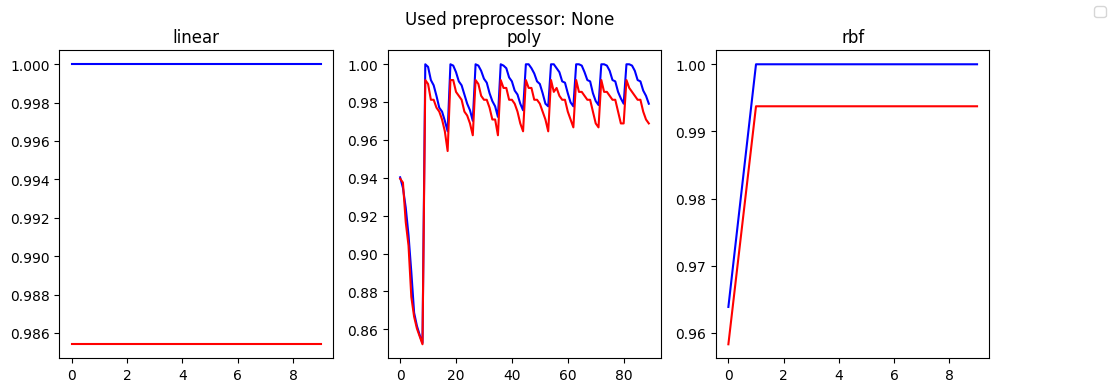

Scaler preprocessor:
linear val score: 0.990
poly   val score: 0.992
rbf    val score: 0.990
----------------------------------------


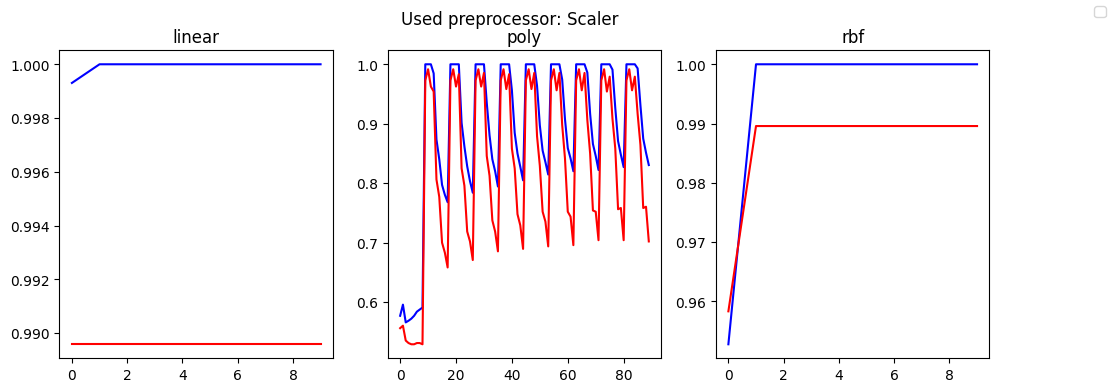

Norm preprocessor:
linear val score: 0.990
poly   val score: 0.998
rbf    val score: 0.998
----------------------------------------


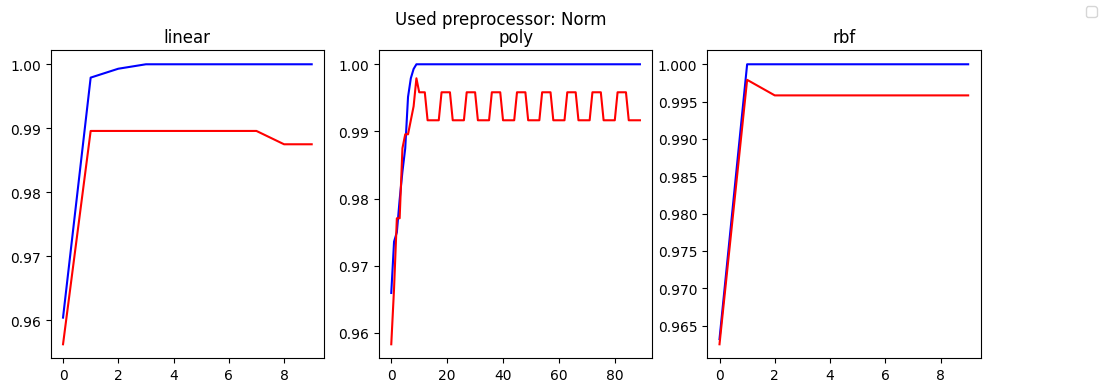

MinMax preprocessor:
linear val score: 0.990
poly   val score: 0.992
rbf    val score: 0.994
----------------------------------------


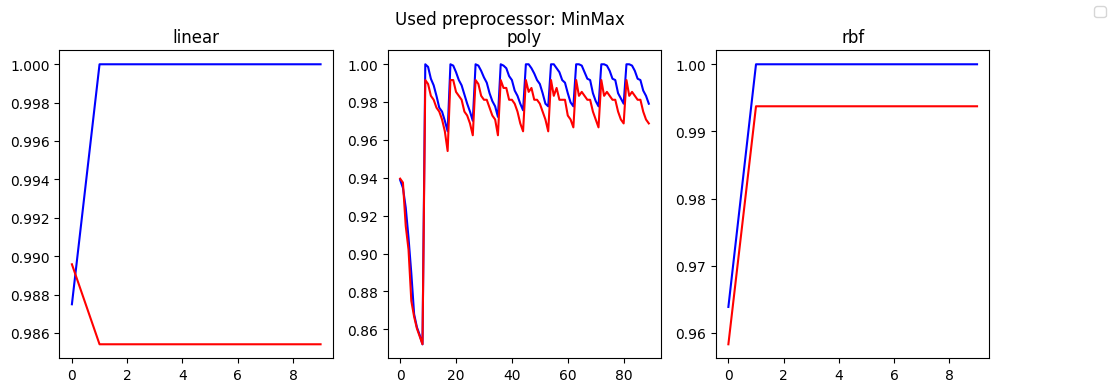

In [14]:
for prep, kernels in trained_svc.items():
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))    
    
    fig.suptitle(f'Used preprocessor: {prep}')
    fig.legend(['train acc', 'validation acc'])
    
    print(f'{prep} preprocessor:')
    for i, (kernel, svc_pack) in enumerate(kernels.items()):
        
        train_score, val_score = svc_pack[2], svc_pack[3]
        print(f'{kernel:6} val score: {np.max(val_score):.3f}')
        
        ax[i].plot(train_score, 'b-')
        ax[i].plot(val_score, 'r-')
        ax[i].set_title(kernel)
        
    print('-' * 40)
    plt.show()

Vykreslím ještě heatmapu s nejlepší validační hodnotou pro každý model.

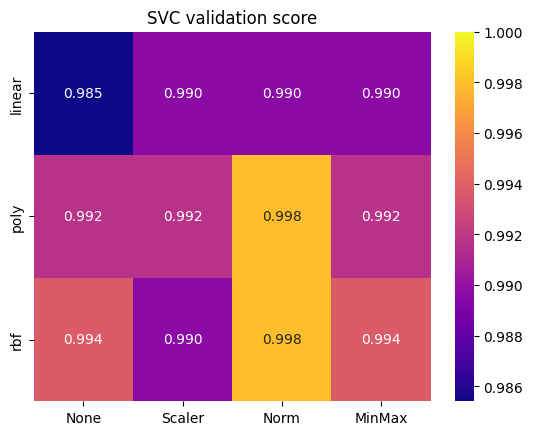

In [15]:
svc_heatmap = pd.DataFrame(trained_svc).applymap(lambda x: np.max(x[3]))
sns.heatmap(svc_heatmap, cmap='plasma', vmin=np.min(svc_heatmap), vmax=1, annot=True, fmt='.3f')
plt.title('SVC validation score')
plt.show()

In [16]:
svc_heatmap.mean().sort_values()

None      0.990278
Scaler    0.990278
MinMax    0.991667
Norm      0.995139
dtype: float64

Podle průměrné validační přesnosti si nejlépe vedly SVC modely s použitím řádkové Normalizace.

In [17]:
svc_best_model = trained_svc['Norm']['rbf']

display(svc_best_model[1])
display(svc_best_model[0])

{'kernel': 'rbf', 'C': 11.12}

Pipeline(steps=[('prep', Normalizer()),
                ('SVC', SVC(C=11.12, random_state=420))])

Můžeme vidět, že nejlépe si vede SVC s Normalizací a poly nebo rbf jádrem.

Obstojně si ale vedly všechny jádra se všemi druhy normalizací.

### Naive Bayes
Použiju model **GaussianNB**, který předpokládá normalitu příznaků a parametry $\sigma$ a $\mu$ odhaduje pomocí metody maximální věrohodnosti (max likelihood). Budu ladit parametr *var_smoothing*.

**GaussianNB** funguje dobře, pokud jsou data rozdělitelná lineárnimi hranicemi. Což by v případě 28x28 obrázků ve stupních šedi mohlo plalit.

Díky předpokladu normality bych si tipnul, že model bude dosahovat větší přesnosti pro normalizovaná data.

In [18]:
from sklearn.naive_bayes import GaussianNB

def train_naive_bayes(params, preprocessor = None) -> list:
    """ Train GaussianNB with given params and given preprocessor """
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)
    
    for params in param_grid:
        
        bayes = Pipeline([
            ('prep', preprocessor),
            ('Bayes', GaussianNB(**params))
        ]).fit(Xtrain, ytrain)
        
        train_score.append(bayes.score(Xtrain, ytrain))
        val_score.append(bayes.score(Xval, yval))
    
    # train best model
    best_params = param_grid[np.argmax(val_score)]
    best_bayes = Pipeline([
        ('prep', preprocessor),
        ('Bayes', GaussianNB(**best_params))
    ]).fit(Xtrain, ytrain)
        
    return [best_bayes, best_params, train_score, val_score]

In [19]:
%%time

trained_bayes = {
    'None' : [],
    'Scaler' : [],
    'Norm' : [],
    'MinMax' : []
}

# train best model for each preprocessing
for prep, name in zip([None, StandardScaler(), Normalizer(), MinMaxScaler()], trained_bayes.keys()):
    
    trained_bayes[name] = train_naive_bayes({
        'var_smoothing' : np.linspace(1e-15, 1e3, 30),
    }, preprocessor = prep)

CPU times: user 8.62 s, sys: 13.2 ms, total: 8.63 s
Wall time: 8.68 s


None preprocessor val score: 0.885
----------------------------------------


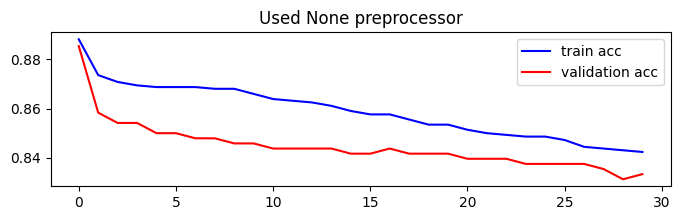

Scaler preprocessor val score: 0.873
----------------------------------------


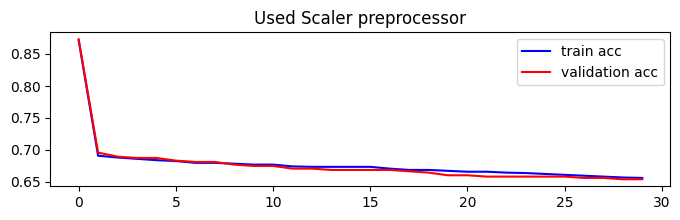

Norm preprocessor val score: 0.956
----------------------------------------


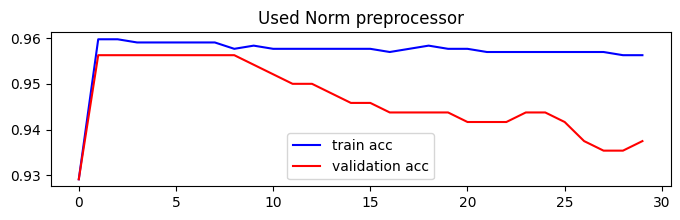

MinMax preprocessor val score: 0.881
----------------------------------------


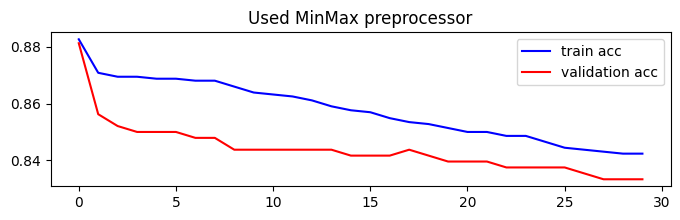

In [20]:
for prep, bayes_pack in trained_bayes.items():
    
    train_score, val_score = bayes_pack[2], bayes_pack[3]
    
    print(f'{prep} preprocessor val score: {np.max(val_score):.3f}')        
    print('-' * 40)
    
    fig, ax = plt.subplots(figsize = (8, 2))
    ax.plot(train_score, 'b-')
    ax.plot(val_score, 'r-')
    
    ax.set_title(f'Used {prep} preprocessor')
    ax.legend(['train acc', 'validation acc'])
    plt.show()

Pro zvyšující se vyhlazování největšího rozptylu přesnost modelu klesá.

Vykreslím validační přesnosti pro všechny kombinace natrénovaných modelů.

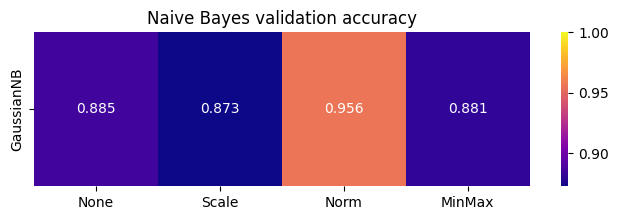

In [21]:
bayes_heatmap = pd.DataFrame({
    'None' : np.max(trained_bayes['None'][3]),
    'Scale' : np.max(trained_bayes['Scaler'][3]),
    'Norm' : np.max(trained_bayes['Norm'][3]),
    'MinMax' : np.max(trained_bayes['MinMax'][3])
}, index=['GaussianNB'])

fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(bayes_heatmap, cmap='plasma', vmin = np.min(bayes_heatmap), vmax = 1, annot = True, fmt = '.3f', ax = ax)
ax.set_title('Naive Bayes validation accuracy')

plt.show()

In [22]:
bayes_best_model = trained_bayes['Norm']

display(bayes_best_model[1])
display(bayes_best_model[0])

{'var_smoothing': 34.48275862068966}

Pipeline(steps=[('prep', Normalizer()),
                ('Bayes', GaussianNB(var_smoothing=34.48275862068966))])

U **GaussianNB** nám podle očekávání vychází nejlépe model s Normalizací.

### LDA
**LinearDiscriminantAnalysis** se snaží maximalizovat rozdíly mezi třídami a minimalizovat jejich rozptyl.
V našem případě by si model měl vést dobře z důvodu klasifikace dvou odlišných tříd. 

Budu ladit hyperparametr *tol*, který se používá v SVD solveru.

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_lda(params, preprocessor = None) -> list:
    """ Train LDA with given params and use given preprocessor """
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)
    
    for params in param_grid:
        
        lda = Pipeline([
            ('prep', preprocessor),
            ('LDA', LinearDiscriminantAnalysis(**params))
        ]).fit(Xtrain, ytrain)
        
        train_score.append(lda.score(Xtrain, ytrain))
        val_score.append(lda.score(Xval, yval))
    
    # train best model
    best_params = param_grid[np.argmax(val_score)]
    best_lda = Pipeline([
        ('prep', preprocessor),
        ('LDA', LinearDiscriminantAnalysis(**best_params))
    ]).fit(Xtrain, ytrain)
        
    return [best_lda, best_params, train_score, val_score]

In [24]:
%%time

trained_lda = {
    'None' : [],
    'Scale' : [],
    'Norm' : [],
    'MinMax' : []
}

for prep, name in zip([None, StandardScaler(), Normalizer(), MinMaxScaler()], trained_lda.keys()):
    trained_lda[name] = train_lda({
        'tol' : np.linspace(1e-5, 1e-1, 20)
    }, preprocessor = prep)

CPU times: user 3min 2s, sys: 59.6 s, total: 4min 2s
Wall time: 1min 8s


None preprocessor val score: 0.979
----------------------------------------


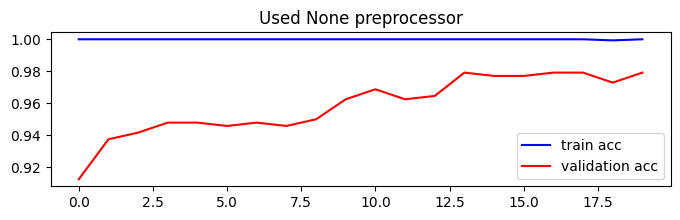

Scale preprocessor val score: 0.979
----------------------------------------


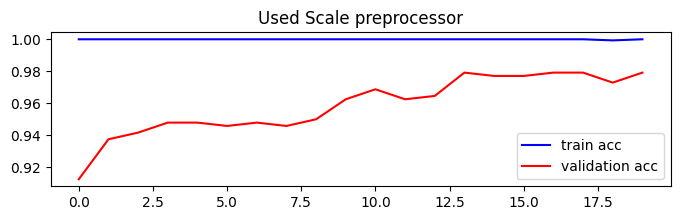

Norm preprocessor val score: 0.977
----------------------------------------


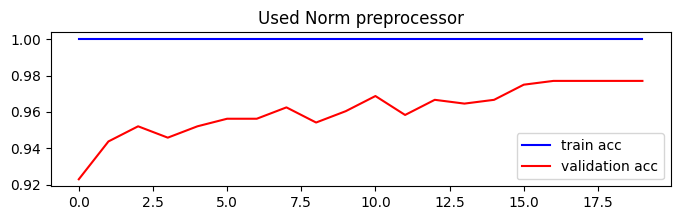

MinMax preprocessor val score: 0.979
----------------------------------------


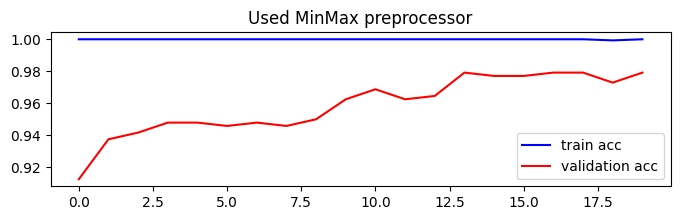

In [25]:
for prep, lda_pack in trained_lda.items():
    
    train_score, val_score = lda_pack[2], lda_pack[3]
    
    print(f'{prep} preprocessor val score: {np.max(val_score):.3f}')        
    print('-' * 40)
    
    fig, ax = plt.subplots(figsize = (8, 2))
    ax.plot(train_score, 'b-')
    ax.plot(val_score, 'r-')
    
    ax.set_title(f'Used {prep} preprocessor')
    ax.legend(['train acc', 'validation acc'])
    plt.show()

Model se s větší tolerancí zlepšuje.

Opět vykreslím heatmapu validačních přesností.

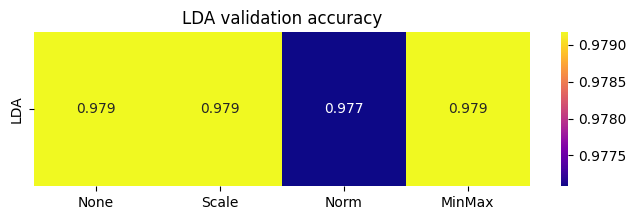

In [26]:
lda_heatmap = pd.DataFrame({
    'None' : np.max(trained_lda['None'][3]),
    'Scale' : np.max(trained_lda['Scale'][3]),
    'Norm' : np.max(trained_lda['Norm'][3]),
    'MinMax' : np.max(trained_lda['MinMax'][3])
}, index = ['LDA'])

fig, ax = plt.subplots(figsize = (8, 2))
sns.heatmap(lda_heatmap, cmap='plasma', vmin = np.min(lda_heatmap), vmax = np.max(lda_heatmap), annot = True, fmt = '.3f', ax = ax)
ax.set_title('LDA validation accuracy')

plt.show()

In [27]:
lda_best_model = trained_lda['None']

display(lda_best_model[1])
display(lda_best_model[0])

{'tol': 0.06842421052631578}

Pipeline(steps=[('prep', None),
                ('LDA', LinearDiscriminantAnalysis(tol=0.06842421052631578))])

V případě **LDA** preprocesory neměly na zlepšení vliv. Dokonce se validační přesnost při použití Normalizace snížila.

## Redukce dimenzionality
V této sekci budu zkoušet metody PCA a LLE pro redukci dimenzionality.

Z důvodu dlouhého trénování a hledání vhodného preprocesoru použiju nejlepší hyperparametry pro nalezení nejlepší redukované dimenze. 

U modelů Naive Bayes a LDA se pokusím počet komponent zahrnout do ladění hyperparametrů. Preprocesor ale použiju podle nejlepšího modelu.

### PCA
V této sekci budu optimální modely trénovat na datech redukovaných pomocí PCA.

Nejdříve si tedy zkusím na trénovacích datech vypsat informace o 30 hlavních komponentách.

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30, random_state = SEED).fit(Xtrain)

for i, var in enumerate(pca.explained_variance_):
    print(f'{i + 1:2}. variance: {var:12.2f} | ratio: {pca.explained_variance_ratio_[i]:6.2f} | cumulated ratio: {pca.explained_variance_ratio_[0:i + 1].sum():6.2f}')

 1. variance:   1055041.22 | ratio:   0.37 | cumulated ratio:   0.37
 2. variance:    455200.21 | ratio:   0.16 | cumulated ratio:   0.52
 3. variance:    137129.34 | ratio:   0.05 | cumulated ratio:   0.57
 4. variance:    112738.27 | ratio:   0.04 | cumulated ratio:   0.61
 5. variance:    105158.91 | ratio:   0.04 | cumulated ratio:   0.65
 6. variance:     78153.21 | ratio:   0.03 | cumulated ratio:   0.67
 7. variance:     60684.05 | ratio:   0.02 | cumulated ratio:   0.70
 8. variance:     43244.59 | ratio:   0.02 | cumulated ratio:   0.71
 9. variance:     38687.30 | ratio:   0.01 | cumulated ratio:   0.72
10. variance:     34525.73 | ratio:   0.01 | cumulated ratio:   0.74
11. variance:     32635.03 | ratio:   0.01 | cumulated ratio:   0.75
12. variance:     28877.58 | ratio:   0.01 | cumulated ratio:   0.76
13. variance:     25931.53 | ratio:   0.01 | cumulated ratio:   0.77
14. variance:     24456.24 | ratio:   0.01 | cumulated ratio:   0.77
15. variance:     22184.76 | ratio

Z výpisu můžeme vidět, že už 17. komponenta obsahuje kumulativní pokrytí dat z 80%. 

#### Redukce na 2 dimenze
Použiju PCA pro redukci na 2 hlavní komponenty a vykreslím scatter plot jednotlivých obrázků s barvou podle kategorie.

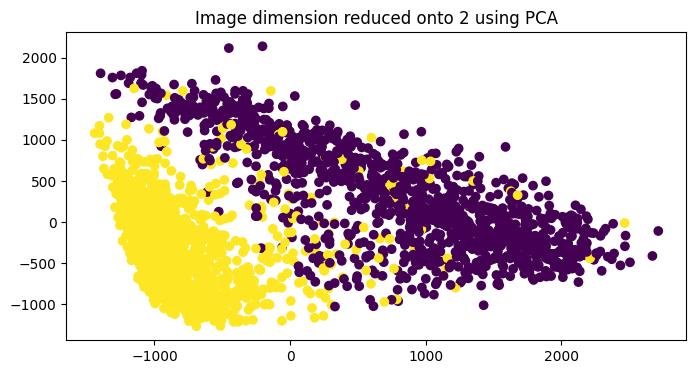

In [29]:
pixels_reduced = PCA(n_components = 2, random_state = SEED).fit_transform(X)

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(pixels_reduced[:, 0], pixels_reduced[:, 1], c = y)
ax.set_title('Image dimension reduced onto 2 using PCA')
plt.show()

Data uričtě nejsou lineárně separabilní, ale i tak můžeme pozorovat lehký náznak rozdělení do dvou kategorií.

### Kvalita obrázků
Vizuálně porovnám ztrátu informace u obrázků při použití PCA.

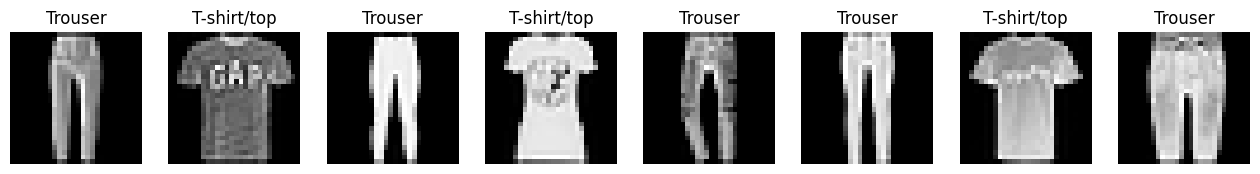

N components: 20


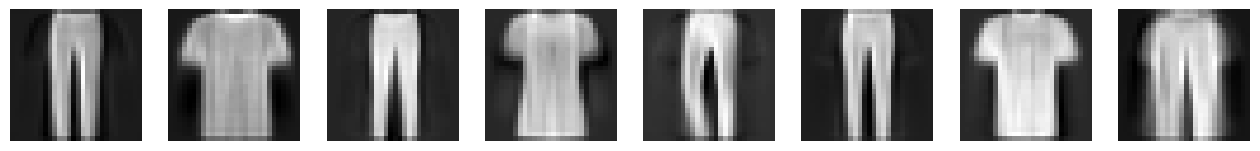

N components: 10


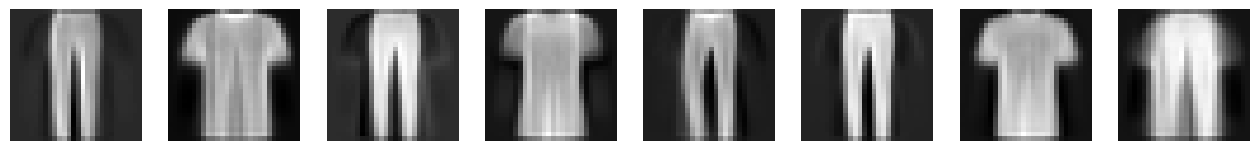

N components: 5


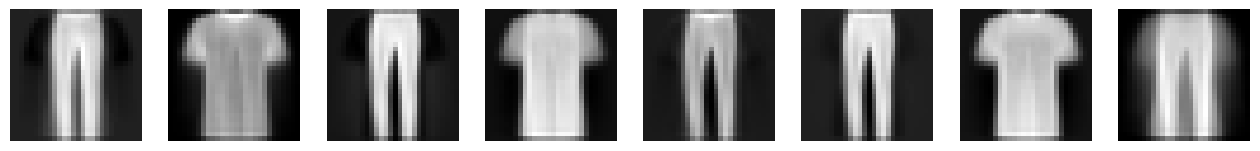

N components: 2


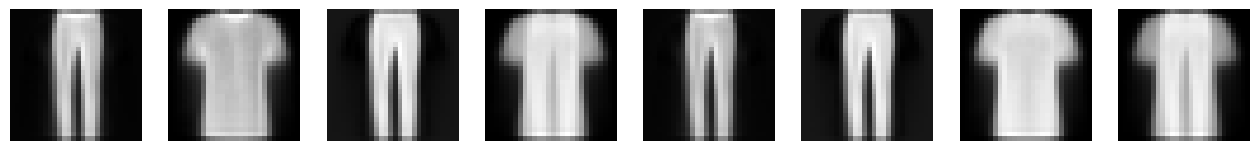

N components: 1


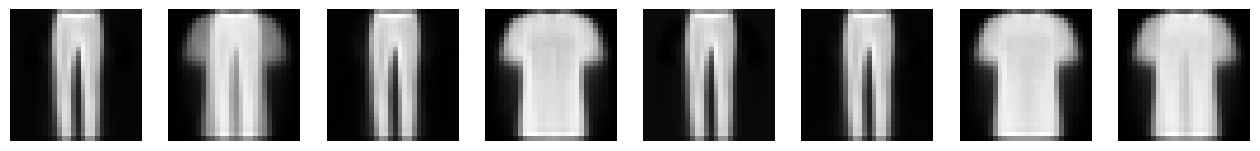

In [30]:
samples = 8
plot_images(X, y, 1, samples)

# plot for n main components
for n in [20, 10, 5, 2, 1]:
    pca = PCA(n_components = n, random_state = SEED).fit(X)
    X_recovered = pca.inverse_transform(pca.transform(X))
    
    print('N components:', n)
    plot_images(X_recovered, y, 1, samples, print_labels = False)

Můžeme vidět, že u posledního obrázku nejde jednoznačně říct, že se jedná o kalhoty při použití pouze 2 hlavních komponent.

Obecně tedy redukce dimenze pomocí PCA zahodí detaily obrázků a zaměřuje se spíše na tvar. To by mohlo být účinné právě při použití LDA.

### Modely s použití PCA

#### SVM
Nejdříve použiju **SVC** na data redukovaná na 2 hlavní komponenty a vykreslím disktriminační čáru spolu s obrazovými body.

Jako hyperparametry použiju nejlepší získané při trénování modelu v předchozí části.

accuracy (train):      0.9590
accuracy (validation): 0.9542



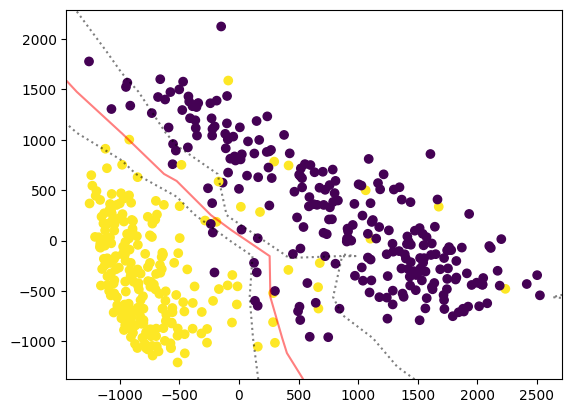

In [31]:
pca = PCA(n_components = 2, random_state = SEED).fit(Xtrain)
Xt_red, Xv_red = pca.transform(Xtrain), pca.transform(Xval)

svc_pca = Pipeline([
    ('norm', Normalizer()),
    ('svm', SVC(**svc_best_model[1], random_state = SEED))
]).fit(Xt_red, ytrain)

print(f'accuracy (train):      {svc_pca.score(Xt_red, ytrain):.4f}')
print(f'accuracy (validation): {svc_pca.score(Xv_red, yval):.4f}\n')

# plot 2 dim pca reduction with discrimination line
plt.scatter(Xv_red[:, 0], Xv_red[:, 1], c = yval)

xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10), np.linspace(ylim[0], ylim[1], 10))

xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = svc_pca.decision_function(xy).reshape(xx.shape)

plt.contour(xx, yy, Z, colors=['k', 'r', 'k'], levels=[-1, 0, 1], alpha=0.5, linestyles=[':', '-', ':'])
plt.show()

Jedná se o stejné obrazové body jako v předchozím grafu s tím rozdílem, že zde vykresluji hodnoty pouze z množiny Xtrain. 

Model data vyseparoval dobře, ale oproti nejlepšímu SVC modelu se zhoršil.

Nyní tedy opět použiju nejlepší parametry **SVC** a jako hyperparametr budu brát počet hlavních komponent PCA. Zároveň data před redukcí normalizuji.

In [32]:
def train_svc_pca(params, prep = None):
    """ Train SVC model using PCA with given params """
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        svc = Pipeline([
            ('norm', prep),
            ('PCA', PCA(**params, random_state = SEED)),
            ('SVC', SVC(**svc_best_model[1], random_state = SEED))
        ]).fit(Xtrain, ytrain)

        train_score.append(svc.score(Xtrain, ytrain))
        val_score.append(svc.score(Xval, yval))
    
    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]
    best_svc = Pipeline([
        ('norm', Normalizer()),
        ('PCA', PCA(**best_params, random_state = SEED)),
        ('SVC', SVC(**svc_best_model[1], random_state = SEED))
    ]).fit(Xtrain, ytrain)
    
    return [best_svc, best_params, train_score, val_score]

In [33]:
%%time
trained_svc_pca = train_svc_pca({
    'n_components' : np.arange(1, 251, 5)
}, Normalizer())

CPU times: user 1min 11s, sys: 48.2 s, total: 2min
Wall time: 31.5 s


best params: {'n_components': 16}
train score:           1.000
validation score:      0.994
best validation score: 0.998
----------------------------------------


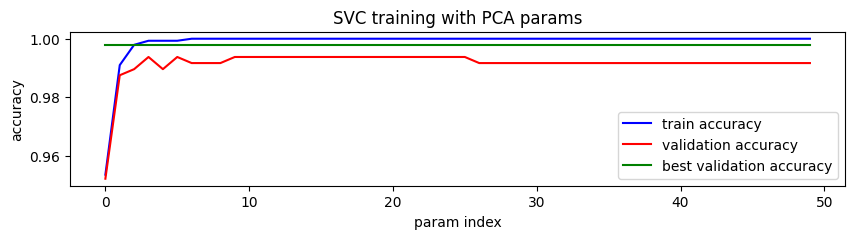

In [34]:
train_score, val_score, svc_max_val = trained_svc_pca[2], trained_svc_pca[3], np.max(svc_best_model[3])

# print training stats
print(f'best params: {trained_svc_pca[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {svc_max_val:.3f}')        
print('-' * 40)

# plot validation accuaracy chart
fig, ax = plt.subplots(figsize = (10, 2))
ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([svc_max_val] * len(val_score), 'g-')
ax.set_title('SVC training with PCA params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

In [35]:
display(trained_svc_pca[1])
display(trained_svc_pca[0])

{'n_components': 16}

Pipeline(steps=[('norm', Normalizer()),
                ('PCA', PCA(n_components=16, random_state=420)),
                ('SVC', SVC(C=11.12, random_state=420))])

Můžeme vidět, že model si nejlépe vede při použití 16 komponent.

I přesto je ale 0.4% horší než původní SVC bez redukce.

#### Naive Bayes
PCA by mohlo způsobit lepší separabilitu dat a v tom případě by si mohl GaussianNB spolu s normalizací polepšít.

In [36]:
def train_bayes_pca(params, prep = None):
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        # train naive bayes
        bayes = Pipeline([
            ('prep', prep),
            ('PCA', PCA(n_components = params['n_components'], random_state = SEED)),
            ('bayes', GaussianNB(var_smoothing = params['var_smoothing']))
        ]).fit(Xtrain, ytrain)
        
        train_score.append(bayes.score(Xtrain, ytrain))
        val_score.append(bayes.score(Xval, yval))

    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]

    best_bayes = Pipeline([
        ('prep', prep),
        ('PCA', PCA(n_components = best_params['n_components'], random_state = SEED)),
        ('bayes', GaussianNB(var_smoothing = best_params['var_smoothing']))
    ]).fit(Xtrain, ytrain)
    
    return [best_bayes, best_params, train_score, val_score]

In [37]:
%%time
trained_bayes_pca = train_bayes_pca({
    'n_components' : np.arange(6, 101, 5),
    'var_smoothing' : np.linspace(1e-15, 1e3, 10)
}, Normalizer())

CPU times: user 2min 34s, sys: 1min 42s, total: 4min 16s
Wall time: 1min 5s


best params: {'var_smoothing': 1e-15, 'n_components': 21}
train score:           0.978
validation score:      0.983
best validation score: 0.956
----------------------------------------


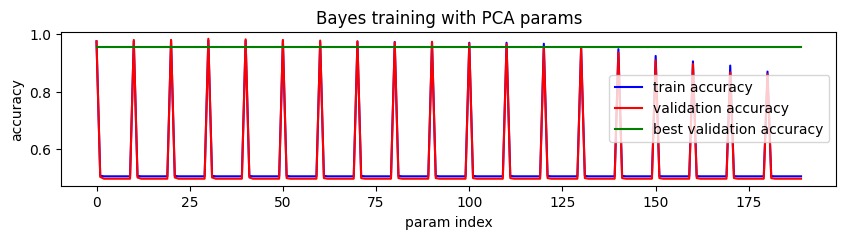

In [38]:
train_score, val_score, bayes_max_val = trained_bayes_pca[2], trained_bayes_pca[3], np.max(bayes_best_model[3])

print(f'best params: {trained_bayes_pca[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {bayes_max_val:.3f}')        
print('-' * 40)

fig, ax = plt.subplots(figsize = (10, 2))

ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([bayes_max_val] * len(val_score), 'g-')
ax.set_title('Bayes training with PCA params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

Můžeme pozorovat, že si model opravdu lépe vede s menším počtem komponent.

Zároveň se validační přesností dostal přes původní model bez redukce.

In [39]:
display(trained_bayes_pca[1])
display(trained_bayes_pca[0])

{'var_smoothing': 1e-15, 'n_components': 21}

Pipeline(steps=[('prep', Normalizer()),
                ('PCA', PCA(n_components=21, random_state=420)),
                ('bayes', GaussianNB(var_smoothing=1e-15))])

Nakonec má model nejlepší validační přesnost pro 21 hlavních komponent s minimálním vyhlazováním rozptylu a normalizací.

#### LDA
U tohoto modelu, jak jsem dříve zmínil, očekávám zlepšení z důvodu odstranění detailů v obrazových datech.

In [40]:
def train_lda_pca(params, prep = None):
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        lda = Pipeline([
            ('prep', prep),
            ('PCA', PCA(n_components = params['n_components'], random_state = SEED)),
            ('LDA', LinearDiscriminantAnalysis(tol = params['tol']))
        ]).fit(Xtrain, ytrain)

        train_score.append(lda.score(Xtrain, ytrain))
        val_score.append(lda.score(Xval, yval))

    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]
    
    best_lda = Pipeline([
        ('prep', prep),
        ('PCA', PCA(n_components = best_params['n_components'], random_state = SEED)),
        ('LDA', LinearDiscriminantAnalysis(tol = best_params['tol']))
    ]).fit(Xtrain, ytrain)
    
    return [best_lda, best_params, train_score, val_score]

In [41]:
%%time
trained_lda_pca = train_lda_pca({ 
    'n_components' : np.arange(1, 251, 5) ,
    'tol' : np.linspace(1e-5, 1e-1, 5)
})

CPU times: user 5min 21s, sys: 3min 32s, total: 8min 54s
Wall time: 2min 16s


best params: {'tol': 1e-05, 'n_components': 51}
train score:           0.997
validation score:      0.992
best validation score: 0.979
----------------------------------------


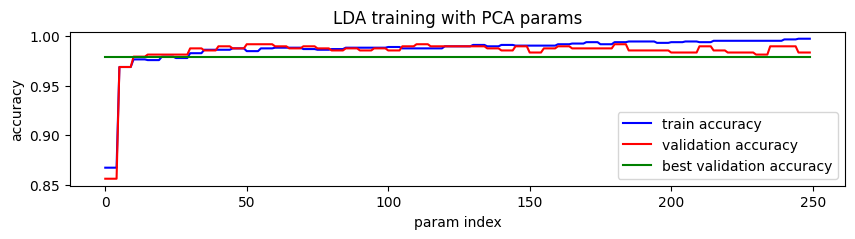

In [42]:
train_score, val_score, lda_max_val = trained_lda_pca[2], trained_lda_pca[3], np.max(lda_best_model[3])

print(f'best params: {trained_lda_pca[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {lda_max_val:.3f}')        
print('-' * 40)

fig, ax = plt.subplots(figsize = (10, 2))

ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([lda_max_val] * len(val_score), 'g-')
ax.set_title('LDA training with PCA params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

Model se validační přesností dostal přes LDA bez redukce.

In [43]:
display(trained_lda_pca[1])
display(trained_lda_pca[0])

{'tol': 1e-05, 'n_components': 51}

Pipeline(steps=[('prep', None), ('PCA', PCA(n_components=51, random_state=420)),
                ('LDA', LinearDiscriminantAnalysis(tol=1e-05))])

Dle vypsaných hodnot a grafu trénování můžeme usoudit, že si LDA vedlo lépe s použitím PCA.

### LLE
Se snaží data projektovat do nižší dimeze pomocí lokálních sousedů.

Opět tedy vykreslím data projektovaná do 2D.

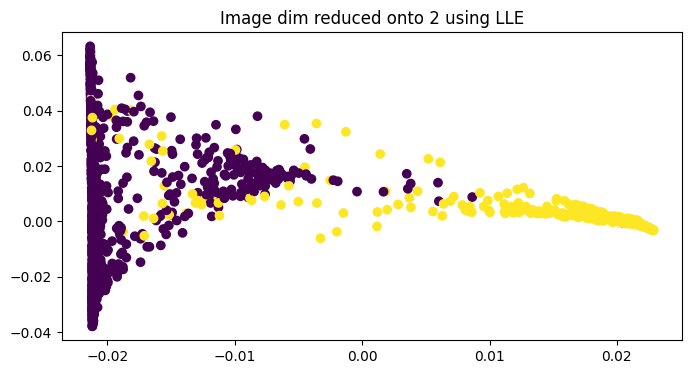

In [44]:
from sklearn.manifold import LocallyLinearEmbedding

pixels_red = LocallyLinearEmbedding(n_neighbors = 10, random_state = SEED).fit_transform(X)

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(pixels_red[:, 0], pixels_red[:, 1], c = y)
ax.set_title('Image dim reduced onto 2 using LLE')
plt.show()

### Modely s použitím LLE

#### SVM
Validační přesnost SVC by se opět neměla zlepšit.

Pro ukázku opět natrénuji model na 2 dimenzionálních datech.

accuracy (train):      0.9722
accuracy (validation): 0.9750



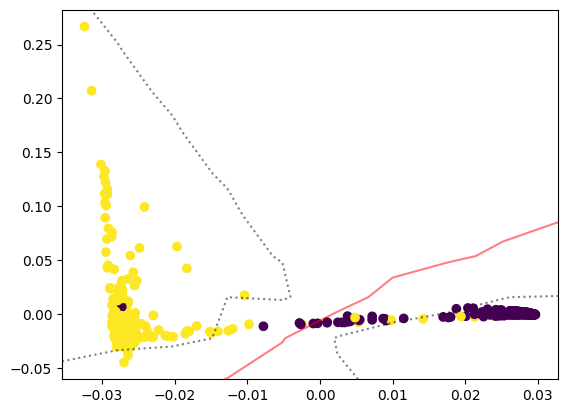

In [45]:
# init lle
lle = LocallyLinearEmbedding(n_neighbors = 10, random_state = SEED).fit(Xtrain)
Xtrain_red, Xval_red = lle.transform(Xtrain), lle.transform(Xval)

# train svc with best params
svc_lle_2dim = Pipeline([
    ('norm', Normalizer()),
    ('svm', SVC(**trained_svc['Norm']['rbf'][1], random_state = SEED))
]).fit(Xtrain_red, ytrain)

print(f'accuracy (train):      {svc_lle_2dim.score(Xtrain_red, ytrain):.4f}')
print(f'accuracy (validation): {svc_lle_2dim.score(Xval_red, yval):.4f}\n')

# plot 2 dim pca reduction with discrimination line
plt.scatter(Xval_red[:, 0], Xval_red[:, 1], c = yval)

xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10), np.linspace(ylim[0], ylim[1], 10))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

Z = svc_lle_2dim.decision_function(xy).reshape(xx.shape)

plt.contour(xx, yy, Z, colors=['k', 'r', 'k'], levels=[-1, 0, 1], alpha=0.5, linestyles=[':', '-', ':'])
plt.show()

SVC nám data vyseparoval vcelku obstojně.

In [46]:
def train_svc_lle(params, prep = None):
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        svc = Pipeline([
            ('norm', prep),
            ('lle', LocallyLinearEmbedding(**params, random_state = SEED)),
            ('SVC', SVC(**svc_best_model[1], random_state = SEED))
        ]).fit(Xtrain, ytrain)

        train_score.append(svc.score(Xtrain, ytrain))
        val_score.append(svc.score(Xval, yval))
    
    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]

    best_svc = Pipeline([
        ('norm', prep),
        ('lle', LocallyLinearEmbedding(**best_params, random_state = SEED)),
        ('svm', SVC(**svc_best_model[1], random_state = SEED))
    ]).fit(Xtrain, ytrain)  
    
    return [best_svc, best_params, train_score, val_score]

In [47]:
%%time
trained_svc_lle = train_svc_lle({
    'n_neighbors' : np.arange(6, 21, 5),
    'n_components' : np.arange(1, 101, 5)
}, Normalizer())

CPU times: user 3min 3s, sys: 28.4 s, total: 3min 31s
Wall time: 1min 20s


best params: {'n_components': 16}
train score:           0.999
validation score:      0.994
best validation score: 0.998
----------------------------------------


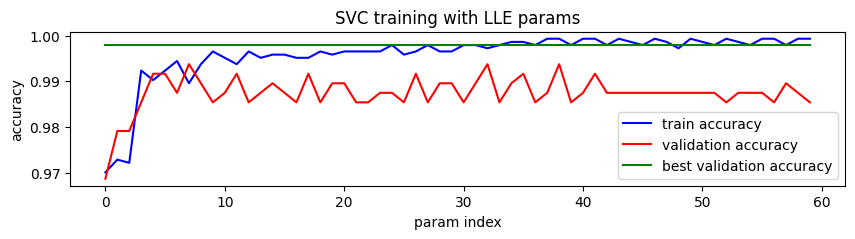

In [48]:
train_score, val_score, svc_max_val = trained_svc_lle[2], trained_svc_lle[3], np.max(svc_best_model[3])

print(f'best params: {trained_svc_pca[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {svc_max_val:.3f}')        
print('-' * 40)

fig, ax = plt.subplots(figsize = (10, 2))

ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([svc_max_val] * len(val_score), 'g-')
ax.set_title('SVC training with LLE params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

Model se opravdu s použítím LLE nezlepšil.

#### Naive Bayes
Zde bych po vzoru PCA opět očekávál lehké zlepšení.

In [49]:
def train_bayes_lle(params, prep = None):
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        bayes = Pipeline([
            ('prep', prep),
            ('lle', LocallyLinearEmbedding(
                n_neighbors = params['n_neighbors'], 
                n_components = params['n_components'],
                random_state = SEED)
            ),
            ('bayes', GaussianNB(var_smoothing = params['var_smoothing']))
        ]).fit(Xtrain, ytrain)

        train_score.append(bayes.score(Xtrain, ytrain))
        val_score.append(bayes.score(Xval, yval))

    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]
    
    best_bayes = Pipeline([
        ('prep', prep),
        ('lle', LocallyLinearEmbedding(
            n_neighbors = best_params['n_neighbors'], 
            n_components = best_params['n_components'],
            random_state = SEED)
        ),
        ('bayes', GaussianNB(var_smoothing = best_params['var_smoothing']))
    ]).fit(Xtrain, ytrain)
    
    return [best_bayes, best_params, train_score, val_score]

In [50]:
%%time
trained_bayes_lle = train_bayes_lle({
    'n_neighbors' : np.arange(6, 21, 5),
    'n_components' : np.arange(1, 31, 5),
    'var_smoothing' : np.linspace(1e-15, 1e3, 2)
}, Normalizer())

CPU times: user 1min 33s, sys: 11.9 s, total: 1min 45s
Wall time: 41 s


best params: {'var_smoothing': 1e-15, 'n_neighbors': 6, 'n_components': 26}
train score:           0.984
validation score:      0.990
best validation score: 0.956
----------------------------------------


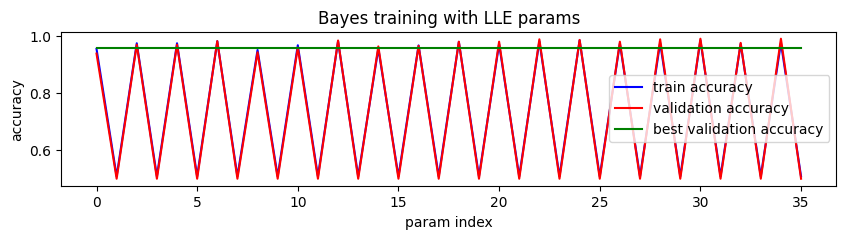

In [51]:
train_score, val_score, bayes_max_val = trained_bayes_lle[2], trained_bayes_lle[3], np.max(bayes_best_model[3])

print(f'best params: {trained_bayes_lle[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {bayes_max_val:.3f}')        
print('-' * 40)

fig, ax = plt.subplots(figsize = (10, 2))

ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([bayes_max_val] * len(val_score), 'g-')
ax.set_title('Bayes training with LLE params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

A opravdu jsme pro nejmenší vyhlazování rozptylu, 26 komponent a 6 sousedů dosáhli lepší validační přesnosti.

#### LDA
Zde budu opět předpokládat lepší validační přesnost.

In [52]:
def train_lda_lle(params, prep = None):
    
    train_score, val_score = [], []
    param_grid = ParameterGrid(params)

    for params in param_grid:

        lda = Pipeline([
            ('prep', prep),
            ('lle', LocallyLinearEmbedding(
                n_neighbors = params['n_neighbors'],
                n_components = params['n_components'],
                random_state = SEED
            )),
            ('LDA', LinearDiscriminantAnalysis(tol = params['tol']))
        ]).fit(Xtrain, ytrain)

        train_score.append(lda.score(Xtrain, ytrain))
        val_score.append(lda.score(Xval, yval))

    # train best model with reduced dim
    best_params = param_grid[np.argmax(val_score)]
    
    best_lda = Pipeline([
        ('prep', prep),
        ('lle', LocallyLinearEmbedding(
            n_neighbors = best_params['n_neighbors'],
            n_components = best_params['n_components'],
            random_state = SEED
        )),
        ('LDA', LinearDiscriminantAnalysis(tol = best_params['tol']))
    ]).fit(Xtrain, ytrain)
    
    return [best_lda, best_params, train_score, val_score]

In [53]:
%%time
trained_lda_lle = train_lda_lle({
    'n_neighbors' : np.arange(6, 21, 5),
    'n_components' : np.arange(1, 51, 5),
    'tol' : np.linspace(1e-5, 1e-1, 5)
})

CPU times: user 7min 42s, sys: 2min 7s, total: 9min 49s
Wall time: 3min 14s


best params: {'tol': 1e-05, 'n_neighbors': 11, 'n_components': 26}
train score:           0.987
validation score:      0.988
best validation score: 0.979
----------------------------------------


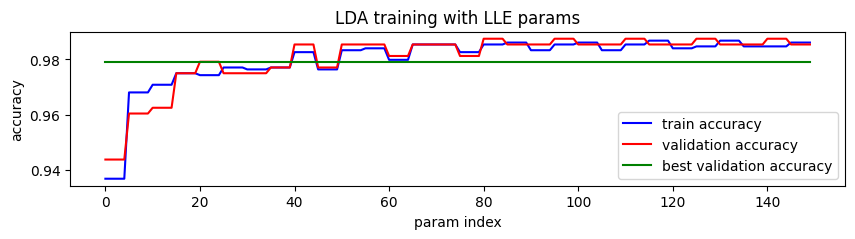

In [54]:
train_score, val_score, lda_max_val = trained_lda_lle[2], trained_lda_lle[3], np.max(lda_best_model[3])

print(f'best params: {trained_lda_lle[1]}')
print(f'train score:           {np.max(train_score):.3f}')        
print(f'validation score:      {np.max(val_score):.3f}')        
print(f'best validation score: {lda_max_val:.3f}')        
print('-' * 40)

fig, ax = plt.subplots(figsize = (10, 2))

ax.plot(train_score, 'b-')
ax.plot(val_score, 'r-')
ax.plot([lda_max_val] * len(val_score), 'g-')
ax.set_title('LDA training with LLE params')
ax.set_ylabel('accuracy')
ax.set_xlabel('param index')
ax.legend(['train accuracy', 'validation accuracy', 'best validation accuracy'])

plt.show()

Pro nejnižší toleranci, 11 sousedů a 26 komponent jsme dosáhli opět lepší validační přesnosti.

## Finální model
Vykreslím heatmapu validačních přesností pro nejlepší modely ze všech kategorií redukce dimenzionality i bez.

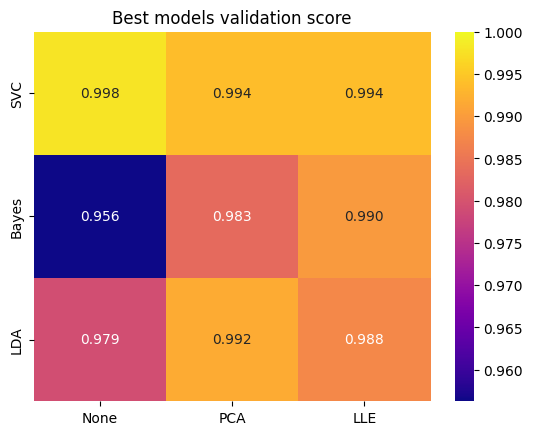

In [55]:
# fill validation accuracy dataframe
final_val_heatmap = pd.DataFrame({
    'None' : [svc_best_model[3], bayes_best_model[3], lda_best_model[3]],
    'PCA' : [trained_svc_pca[3], trained_bayes_pca[3], trained_lda_pca[3]],
    'LLE' : [trained_svc_lle[3], trained_bayes_lle[3], trained_lda_lle[3]]
}, index = ['SVC', 'Bayes', 'LDA'])

# get max validation accuracy
final_val_heatmap = final_val_heatmap.applymap(lambda x: np.max(x))

# plot heatmap
sns.heatmap(final_val_heatmap, cmap = 'plasma', vmin = np.min(final_val_heatmap), vmax = 1, annot = True, fmt = '.3f')
plt.title('Best models validation score')
plt.show()

Nejlepší validační přesnost měl model **SVC** bez použití redukce dimenzionality s normalizací a rbf jádrem.

Ještě vypíšu průměrné validační přesnosti pro různé metody redukce dimenze a pro modely.

In [56]:
print('Dimension reduction mean')
display(final_val_heatmap.mean(axis = 0).sort_values())

print('\nModel accuracy mean')
display(final_val_heatmap.mean(axis = 1).sort_values())

Dimension reduction mean


None    0.977778
PCA     0.989583
LLE     0.990278
dtype: float64


Model accuracy mean


Bayes    0.976389
LDA      0.986111
SVC      0.995139
dtype: float64

V prúměru si nejlépe modely vedly př použití **LLE** a zároveň si nejlépe vedl model **SVC**.

Použiju tedy SVC bez metod redukce dimenze a otesuji jeho přesnost na testovácích datech, které model ještě neviděl.

In [57]:
display(svc_best_model[1])
display(svc_best_model[0])

print(f"train score:      {svc_best_model[0].score(Xtrain, ytrain):.3f}")
print(f"validation score: {svc_best_model[0].score(Xval, yval):.3f}")
print(f"test score:       {svc_best_model[0].score(Xtest, ytest):.3f}")

{'kernel': 'rbf', 'C': 11.12}

Pipeline(steps=[('prep', Normalizer()),
                ('SVC', SVC(C=11.12, random_state=420))])

train score:      1.000
validation score: 0.998
test score:       0.990


Mohu tedy předpokládat, že model bude mít přibližně **99%** přesnost na datech, které nikdy neviděl.